In [ ]:
# GRADED LAB
# Data preprocessing

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((10000, 28, 28, 1)).astype('float32') / 255


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Cnn model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model compilation and evaluation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history=model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8532 - loss: 0.4807 - val_accuracy: 0.9740 - val_loss: 0.0816
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9806 - loss: 0.0617 - val_accuracy: 0.9839 - val_loss: 0.0502
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9886 - loss: 0.0383 - val_accuracy: 0.9871 - val_loss: 0.0424
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9906 - loss: 0.0295 - val_accuracy: 0.9868 - val_loss: 0.0471
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9924 - loss: 0.0232 - val_accuracy: 0.9896 - val_loss: 0.0350
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9865 - loss: 0.0381
Test Accuracy: 0.9906


**Plot**

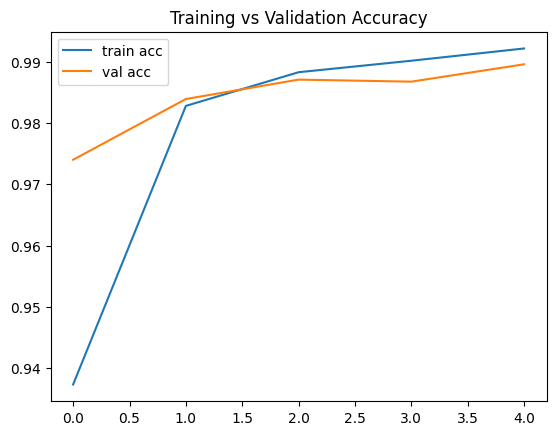

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

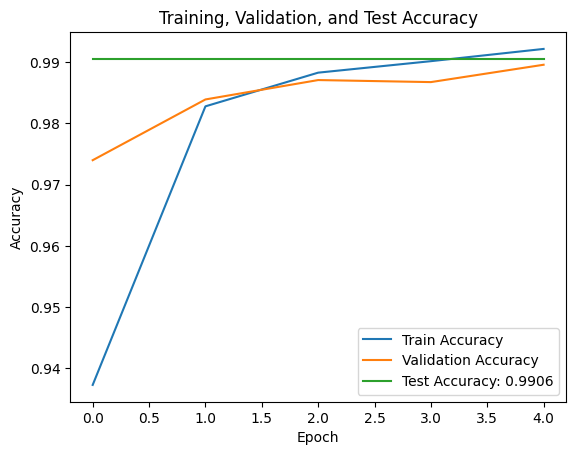

In [ ]:
test_acc_list = [test_acc] * len(history.history['accuracy'])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(test_acc_list, label=f'Test Accuracy: {test_acc:.4f}')

plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Animal Image DATASET**

In [ ]:
import tensorflow as tf
import kagglehub, pathlib, os, random, itertools

kaggle_path = kagglehub.dataset_download(
    "ashishsaxena2209/animal-image-datasetdog-cat-and-panda"
)

def find_image_root(root: pathlib.Path):
    for p, d, f in os.walk(root):

        subdirs = [pathlib.Path(p)/sd for sd in d]
        if len(subdirs) >= 2 and all(
            len(list(itertools.islice(
                (f for f in os.scandir(sd) if f.name.lower().endswith(('.jpg', '.png'))), 10))) >= 10
            for sd in subdirs):
            return pathlib.Path(p)
    raise RuntimeError("Could not locate image folders automatically")

data_dir = find_image_root(pathlib.Path(kaggle_path))
print("✓ Image root found at:", data_dir)


IMG_SIZE  = (64, 64)
BATCH     = 32
SEED      = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)

print("Classes detected →", train_ds.class_names)
num_classes = len(train_ds.class_names)

for _, y in train_ds.take(1):
    print("Sample integer labels:", y.numpy()[:10])

norm = tf.keras.layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds
            .map(lambda x, y: (norm(x), y))
            .cache()
            .prefetch(buffer_size=AUTOTUNE))
val_ds   = (val_ds
            .map(lambda x, y: (norm(x), y))
            .cache()
            .prefetch(buffer_size=AUTOTUNE))


✓ Image root found at: /kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals
Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.
Classes detected → ['cats', 'dogs', 'panda']
Sample integer labels: [0 2 0 0 0 2 0 2 1 0]


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding="same", activation="relu",
                  input_shape=(*IMG_SIZE, 3), kernel_regularizer=l2(0.0095)),
    layers.BatchNormalization(), layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding="same", activation="relu",
                  kernel_regularizer=l2(0.0095)),
    layers.BatchNormalization(), layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding="same", activation="relu",
                  kernel_regularizer=l2(0.0095)),
    layers.BatchNormalization(), layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

optimizer=Adam(learning_rate=0.001)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


val_loss, val_acc = model.evaluate(val_ds)
print(f"\nFinal validation accuracy: {val_acc:.4f}")

# 73% accuracy is decent for a model that predicts 3 image classification cats, dogs, pandas as training accuracy is 93% and validation is 73% it suggests slight overfitting in data
# which can later be improved by tranfer learning and data augmentation techniques

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - accuracy: 0.5623 - loss: 3.0229 - val_accuracy: 0.3467 - val_loss: 7.4592
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 389ms/step - accuracy: 0.6588 - loss: 1.8243 - val_accuracy: 0.3817 - val_loss: 6.2667
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.7076 - loss: 1.5531 - val_accuracy: 0.3800 - val_loss: 4.6998
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 388ms/step - accuracy: 0.7188 - loss: 1.3527 - val_accuracy: 0.3317 - val_loss: 3.8894
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 406ms/step - accuracy: 0.7548 - loss: 1.1749 - val_accuracy: 0.4717 - val_loss: 1.7215
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 389ms/step - accuracy: 0.7394 - loss: 1.1240 - val_accuracy: 0.5317 - val_loss: 1.8433
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 388ms/step - accuracy: 0.7617 - loss: 0.9816 - val_accuracy: 0.6650 - val_loss: 1.4518
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 390ms/step - accuracy: 0.7780 - loss: 0.9081 - val_accu

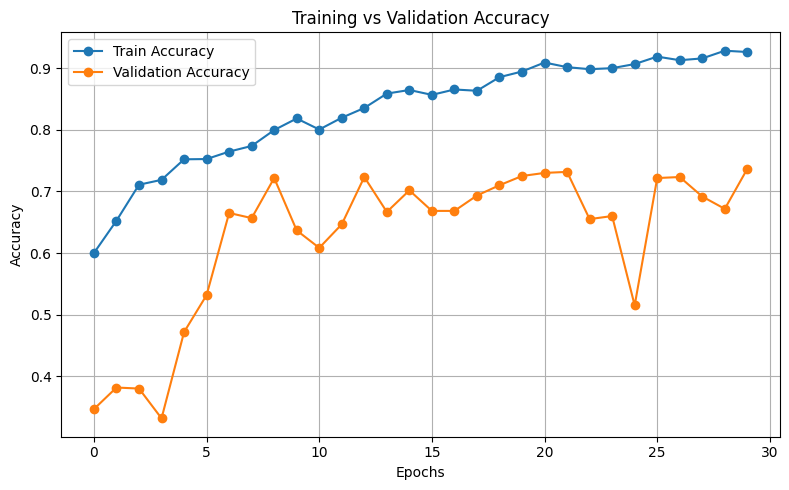

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

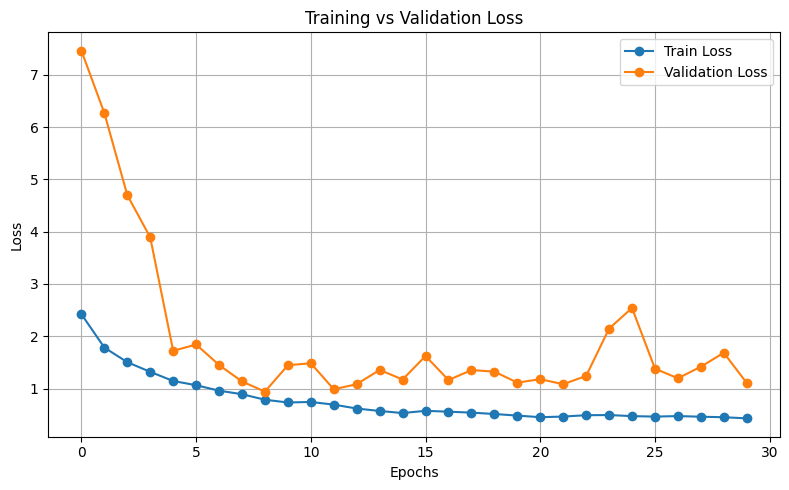

In [ ]:
# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()